In [1]:
## импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
from sympy import symbols, Eq, solve
import warnings

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Загрузка и проверка данных

In [3]:
deliver = pd.read_excel('data/Test data - analytics.xlsx', sheet_name='Delliveries')
tariff = pd.read_excel('data/Test data - analytics.xlsx', sheet_name='Tariff')

In [4]:
deliver.head()

,Client,Week,Distance,Number of parcels
0,А,2023-03-16,10.017112,3
1,А,2023-03-13,4.201492,2
2,А,2023-03-13,16.400596,5
3,А,2023-03-15,6.283481,3
4,А,2023-03-15,3.389424,2


- переименнуем последнюю переменную для улаления пробелов

In [5]:
deliver = deliver.rename(columns={'Number of parcels': 'Num_of_parcels'})

In [6]:
deliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Client          199 non-null    object        
 1   Week            199 non-null    datetime64[ns]
 2   Distance        199 non-null    float64       
 3   Num_of_parcels  199 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.3+ KB


- переменная week уже определена в формате datetime

In [7]:
deliver.isna().sum().sum()

0

- нет пропущенных значений во фрейме deliver 

In [8]:
tariff.head() 

,Unnamed: 0,Unnamed: 1
0,Tariffs per parcel,NaN
1,А,5.0
2,Б,6.0
3,С,8.0
4,Courier price per km,1.2


- зададим названия для колонок для читабельности и удобства в работе

In [9]:
tariff = tariff.drop(index=0)
tariff = tariff.rename(columns={"Unnamed: 0": "Client", "Unnamed: 1": "Tariff_rate"})
tariff

,Client,Tariff_rate
1,А,5.0
2,Б,6.0
3,С,8.0
4,Courier price per km,1.2


### **Задания**
------------------------

### 1. Посчитать выручку, издержки, прибыль, take rate (прибыль/выручку) за недели 13.03 и 20.03

#### 1.1 Подсчет выручки

- отсортируем таблицу для вывода только тех посылок, которые были осуществлены в промежуток между 13.03 по 19.03

In [10]:
deliver_week1 = deliver.query('Week >= "2023-03-13" and Week <= "2023-03-19"')
deliver_week1.head()

,Client,Week,Distance,Num_of_parcels
0,А,2023-03-16,10.017112,3
1,А,2023-03-13,4.201492,2
2,А,2023-03-13,16.400596,5
3,А,2023-03-15,6.283481,3
4,А,2023-03-15,3.389424,2


In [11]:
print('Список дней после сортировки:')
display(sorted(deliver_week1['Week'].unique()))
print()
print('Количество дней:', deliver_week1['Week'].nunique())

Список дней после сортировки:


[numpy.datetime64('2023-03-13T00:00:00.000000000'),
 numpy.datetime64('2023-03-14T00:00:00.000000000'),
 numpy.datetime64('2023-03-15T00:00:00.000000000'),
 numpy.datetime64('2023-03-16T00:00:00.000000000'),
 numpy.datetime64('2023-03-17T00:00:00.000000000'),
 numpy.datetime64('2023-03-18T00:00:00.000000000'),
 numpy.datetime64('2023-03-19T00:00:00.000000000')]


Количество дней: 7


- В отсортированном фрейме содержится информация по каждому дню в период с 13.03.2023 по 20.03.2023
- В промежуток между этими датами (включительно) попали 8 дней

Агрегируем количество доставленных посылок по трем клиентам А, Б и С.

In [12]:
count_by_client1 = deliver_week1.groupby('Client').agg({'Num_of_parcels': 'sum'}).reset_index()
count_by_client1

,Client,Num_of_parcels
0,А,76
1,Б,152
2,С,147


- Умножим количество доставленных посылок в период с 13.03.2023 по 19.03.2023 на тарифную ставку за одну посылку для каждого клиента.
- Так мы узнаем выручку по каждому клиенту.
- Информация о тарифах для оплаты посылок для каждого клиента содержится в таблице ``tariff``. 
- Поэтому нужно соединить значения тарифных ставок для каждого клиента, используя колонку ``tariff.Client`` как ключ.

In [13]:
count_by_client_tariff1 = pd.merge(count_by_client1, tariff, on='Client')
count_by_client_tariff1

,Client,Num_of_parcels,Tariff_rate
0,А,76,5.0
1,Б,152,6.0
2,С,147,8.0


In [14]:
count_by_client_tariff1['Revenue'] = count_by_client_tariff1['Num_of_parcels'] * count_by_client_tariff1['Tariff_rate']
count_by_client_tariff1

,Client,Num_of_parcels,Tariff_rate,Revenue
0,А,76,5.0,380.0
1,Б,152,6.0,912.0
2,С,147,8.0,1176.0


- Теперь можно вычислить сумму выручки, принесенную каждым клиентом, чтобы узнать общий объем выручки от поставок посылок клиентам в период с 13.03.2023 по 19.03.2023.

In [15]:
print('Общий объем выручки в период с 13.03 по 19.03:', sum(count_by_client_tariff1['Revenue']), 'у.е.')

Общий объем выручки в период с 13.03 по 19.03: 2468.0 у.е.


- Пропишем функцию для автоматизации задачи по рассчету выручки за выбранную неделю:

In [16]:
def calc_revenue(date1, date2):
    
    deliver_week = deliver.query('Week >= @date1 and Week <= @date2')
    
    count_by_client = deliver_week.groupby('Client').agg({'Num_of_parcels': 'sum'}).reset_index()
    
    count_by_client_tariff = pd.merge(count_by_client, tariff, on='Client')
    
    count_by_client_tariff['Revenue'] = count_by_client_tariff['Num_of_parcels'] * count_by_client_tariff['Tariff_rate']
    
    print(f'Общий объем выручки в период с {date1} по {date2}:', sum(count_by_client_tariff['Revenue']), 'у.е.')
    return sum(count_by_client_tariff['Revenue'])

In [17]:
rev_week1 = calc_revenue('2023-03-13', '2023-03-19')

Общий объем выручки в период с 2023-03-13 по 2023-03-19: 2468.0 у.е.


In [18]:
rev_week2 = calc_revenue('2023-03-20', '2023-03-26')

Общий объем выручки в период с 2023-03-20 по 2023-03-26: 2249.0 у.е.


#### 1.2 Подсчет издержек

- Издержки составляют оплату зактрат на доставку посылок клиентам.
- Каждому клиенту корреспондирует значение расстояния:

In [19]:
deliver.head()

,Client,Week,Distance,Num_of_parcels
0,А,2023-03-16,10.017112,3
1,А,2023-03-13,4.201492,2
2,А,2023-03-13,16.400596,5
3,А,2023-03-15,6.283481,3
4,А,2023-03-15,3.389424,2


- Значения дистанции (км) до клиента нужно  умножить на курьерскую ставку за один км.
- Значение курьерской ставки за км находится в таблице ``tariff``:

In [20]:
tariff.loc[4:]

,Client,Tariff_rate
4,Courier price per km,1.2


In [21]:
courier_rate = tariff.iloc[3,1]
courier_rate # сохраним значение курьерской ставки за км в отдельную переменную

1.2

- Пропишем функцию, которая будет агрегировать расстояние по клиенту, расчитает расходы поклиентно и общуюю сумму издержек:

In [22]:
def calc_cost(date1, date2, rate):
    
    dist_week = deliver.query('Week >= @date1 and Week <= @date2')
    
    dist_by_client = dist_week.groupby('Client').agg({'Distance': 'sum'}).reset_index()
    
    dist_by_client['Cost'] = dist_by_client['Distance'] * rate
    
    print(f'Общий объем издержек в период с {date1} по {date2}:', round(sum(dist_by_client['Cost']), 2), 'у.е.')
    return sum(dist_by_client['Cost'])

In [23]:
cost_week1 = calc_cost('2023-03-13', '2023-03-19', courier_rate)

Общий объем издержек в период с 2023-03-13 по 2023-03-19: 1235.33 у.е.


In [24]:
cost_week2 = calc_cost('2023-03-20', '2023-03-26', courier_rate)

Общий объем издержек в период с 2023-03-20 по 2023-03-26: 1407.11 у.е.


#### 1.3 Расчет прибыли

Вычтем из показателей выручки по неделям недельные издержки, чтобы получить прибыль за каждую из двух недель.

In [25]:
profit_week1 = rev_week1 - cost_week1
print('Итого прибыль за первую неделю (2023-03-13 - 2023-03-19):', round(profit_week1, 2), 'у.е.')

Итого прибыль за первую неделю (2023-03-13 - 2023-03-19): 1232.67 у.е.


In [26]:
profit_week2 = rev_week2 - cost_week2
print('Итого прибыль за вторую неделю (2023-03-20 - 2023-03-26):', round(profit_week2, 2), 'у.е.')

Итого прибыль за вторую неделю (2023-03-20 - 2023-03-26): 841.89 у.е.


#### 1.4 Take rate (прибыль / выручку)

- Take rate для первой недели (13.03.23 - 19.03.23):

In [27]:
take_rate_week1 = profit_week1 / rev_week1
print("Take rate для периода с с 2023-03-13 по 2023-03-19:", round(take_rate_week1, 3))

Take rate для периода с с 2023-03-13 по 2023-03-19: 0.499


- Take rate для второй недели (20.03.23 - 26.03.23):

In [28]:
take_rate_week2 = profit_week2 / rev_week2
print("Take rate для периода с 2023-03-20 по 2023-03-26:", round(take_rate_week2, 3))

Take rate для периода с 2023-03-20 по 2023-03-26: 0.374


### 2. Как take rate изменился на прошлой неделе? Назовите 1-2 основных причины

In [29]:
print('По сравнению со второй неделей (с 2023-03-20 по 2023-03-26) на первой неделе take rate был выше на:', round(take_rate_week1 - take_rate_week2, 3))

По сравнению со второй неделей (с 2023-03-20 по 2023-03-26) на первой неделе take rate был выше на: 0.125


- *То есть на второй неделе take rate упал по сравнению с первой на 0.125*

**Причины изменения take rate:**

#### 2.1 Спад прибыли

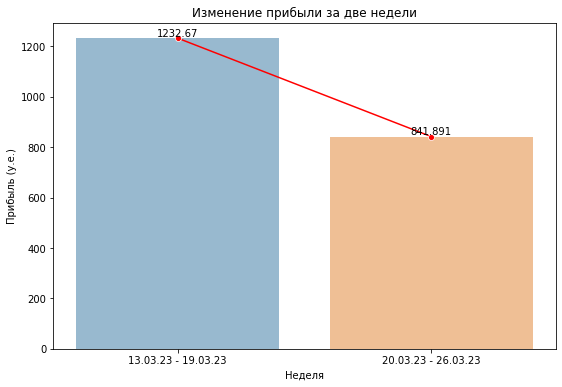

In [30]:
prof_df = pd.DataFrame({'Неделя': ['13.03.23 - 19.03.23', '20.03.23 - 26.03.23'],
                       'Прибыль (у.е.)': [profit_week1, profit_week2]})

fig, ax = plt.subplots()
fig.set_size_inches(9, 6, forward=True)
ax = sns.barplot(x='Неделя', y='Прибыль (у.е.)', data=prof_df, alpha=0.5)
for i in ax.containers:
    ax.bar_label(i,)
sns.lineplot(x='Неделя', y='Прибыль (у.е.)', data=prof_df, marker='o', color='red')
plt.title('Изменение прибыли за две недели')
plt.show()

- *Как видно на графике выше, на первой неделе прибыль от посылок была выше, по сравнению со второй неделей*

In [31]:
print("На второй неделе (20.03.23 - 26.03.23) прибыль сократилась на:", round(profit_week1 - profit_week2, 2), 'у.е.')

На второй неделе (20.03.23 - 26.03.23) прибыль сократилась на: 390.78 у.е.


In [32]:
print("Это сокращение на", round((profit_week1 - profit_week2) / profit_week1 * 100, 2), '% по сравнению с объемом прибыли на первой неделе (13.03.23 - 19.03.23)')

Это сокращение на 31.7 % по сравнению с объемом прибыли на первой неделе (13.03.23 - 19.03.23)


- *Тем самым, спад показателя прибыли (на 31.7%) на второй неделе привел к снижению take rate на второй неделе (20.03.23 - 26.03.23)*
- *Так как прибыль на первой неделе (13.03.23 - 19.03.23) была выше, то и take rate, соответственно, так же принимал более высокое значение*

#### 2.2 Снижение выручки

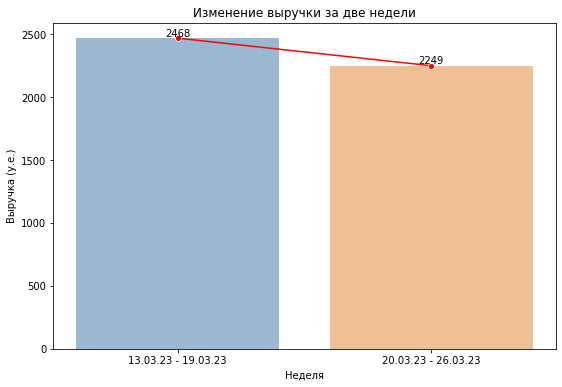

In [33]:
rev_df = pd.DataFrame({'Неделя': ['13.03.23 - 19.03.23', '20.03.23 - 26.03.23'],
                       'Выручка (у.е.)': [rev_week1, rev_week2]})

fig, ax = plt.subplots()
fig.set_size_inches(9, 6, forward=True)
ax = sns.barplot(x='Неделя', y='Выручка (у.е.)', data=rev_df, alpha=0.5)
for i in ax.containers:
    ax.bar_label(i,)
sns.lineplot(x='Неделя', y='Выручка (у.е.)', data=rev_df, marker='o', color='red')
plt.title('Изменение выручки за две недели')
plt.show()

- *Как видно на графике выше, на первой неделе выручка от посылок также была выше, по сравнению со второй неделей*

In [34]:
print("На второй неделе (20.03.23 - 26.03.23) выручка сократилась на:", rev_week1 - rev_week2, 'у.е.')

На второй неделе (20.03.23 - 26.03.23) выручка сократилась на: 219.0 у.е.


In [35]:
print("Это сокращение на", round((rev_week1 - rev_week2) / rev_week1 * 100, 2), '% по сравнению с объемом выручки на первой неделе (13.03.23 - 19.03.23)')

Это сокращение на 8.87 % по сравнению с объемом выручки на первой неделе (13.03.23 - 19.03.23)


#### 2.3 Увеличение издержек

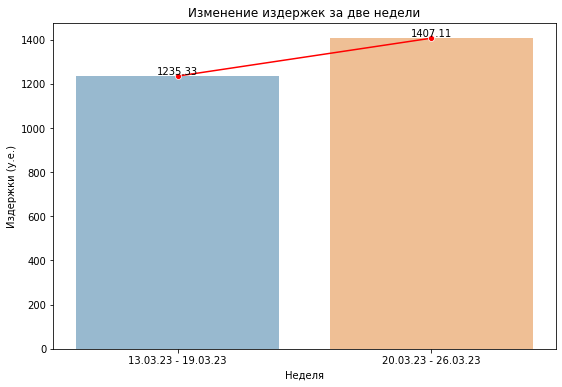

In [36]:
cost_df = pd.DataFrame({'Неделя': ['13.03.23 - 19.03.23', '20.03.23 - 26.03.23'],
                       'Издержки (у.е.)': [cost_week1, cost_week2]})

fig, ax = plt.subplots()
fig.set_size_inches(9, 6, forward=True)
ax = sns.barplot(x='Неделя', y='Издержки (у.е.)', data=cost_df, alpha=0.5)
for i in ax.containers:
    ax.bar_label(i,)
sns.lineplot(x='Неделя', y='Издержки (у.е.)', data=cost_df, marker='o', color='red')
plt.title('Изменение издержек за две недели')
plt.show()

In [37]:
print("На второй неделе (20.03.23 - 26.03.23) издержки увеличились на:", round(cost_week2 - cost_week1, 2), 'у.е.')

На второй неделе (20.03.23 - 26.03.23) издержки увеличились на: 171.78 у.е.


In [38]:
print("Это увеличение на", round((cost_week2 - cost_week1) / cost_week1 * 100, 2), '% по сравнению с объемом издержек на первой неделе (13.03.23 - 19.03.23)')

Это увеличение на 13.91 % по сравнению с объемом издержек на первой неделе (13.03.23 - 19.03.23)


- *Как видно, снижение take rate связано со спадом недельного показателя выручки и прибыли.
- *Для того, чтобы take rate не снижался, необходимо, чтобы недельные показатели издержек оставались на том же уровне или снижались.*
- *Тогда при прежних объемах выручки (или при небольшом спаде), но при снижении издержек показатель прибыли выростет. В результате take rate также возрастет.*
- *С другой стороны, при сохранении прежних объемов издержек, можно увеличить показатель прибыли, повысив выручку с посылок клиентам. Например, можно увеличить, тарифные ставки. Тогда показатель прибыли вырастет, как и take rate, соответсвенно.*

### 3. Предложите несколько вариантов иннициатив, включающие изменение курьерских тарифов и/или изменение клиентских тарифов, которые позволят вернуться на изначальный уровень take rate 

#### 3.1 Сценарий снижения курьерских тарифов при сохранении показателей выручки и прибыли в период 20.03.23 - 26.03.23

- Какие значения курьерских тарифов нужны, для того, чтобы take rate вышел на уровень первой недели (13.03.23 - 19.03.23) или выше? 

In [39]:
courier_rate # изначальный курьерский тариф

1.2

Создадим список с поэтапным снижением курьерского тарифа на 0.1:

In [40]:
courier_rate_list = [round(courier_rate - x * 0.1, 1) for x in range(1, 11)]
courier_rate_list

[1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

Заново создадим фрейм со значениями издержек по клиентам при изначальной курьерской ставки:

In [41]:
dist_week2 = deliver.query('Week >= "2023-03-20" and Week <= "2023-03-26"')
dist_by_client = dist_week2.groupby('Client').agg({'Distance': 'sum'}).reset_index()  
dist_by_client['Cost'] = dist_by_client['Distance'] * courier_rate
dist_by_client

,Client,Distance,Cost
0,А,636.341028,763.609234
1,Б,437.464589,524.957507
2,С,98.785313,118.542376


Создадим цикл, который будет создавать новые колонки рассчитанных значений издержек при постепенном снижении курьерской ставки от -0.1 до -1.0:

In [42]:
for i in range(len(courier_rate_list)):
    column_name = 'Cost_minus_{}'.format(round((i/10)+0.1, 1))
    dist_by_client[column_name] = dist_by_client['Distance'] * courier_rate_list[i]

if 'Cost_minus_0.0' in dist_by_client.columns:
    dist_by_client = dist_by_client.rename(columns={'Cost_minus_0.0': 'Cost_minus_0.1'})

In [43]:
dist_by_client

,Client,Distance,Cost,Cost_minus_0.1,Cost_minus_0.2,Cost_minus_0.3,Cost_minus_0.4,Cost_minus_0.5,Cost_minus_0.6,Cost_minus_0.7,Cost_minus_0.8,Cost_minus_0.9,Cost_minus_1.0
0,А,636.341028,763.609234,699.975131,636.341028,572.706926,509.072823,445.438720,381.804617,318.170514,254.536411,190.902309,127.268206
1,Б,437.464589,524.957507,481.211048,437.464589,393.718130,349.971671,306.225212,262.478753,218.732295,174.985836,131.239377,87.492918
2,С,98.785313,118.542376,108.663844,98.785313,88.906782,79.028251,69.149719,59.271188,49.392657,39.514125,29.635594,19.757063


Теперь для каждого случая снижения курьерской ставки подсчитаем сумму расходов по клиентам.

Для этого создадим список с новыми суммами расходов:

In [44]:
cost_with_rates = [dist_by_client[column].sum() for column in dist_by_client.columns if column.startswith('Cost_minus_')]
cost_with_rates

[1289.850023713017,
 1172.5909306481974,
 1055.3318375833776,
 938.0727445185579,
 820.813651453738,
 703.5545583889184,
 586.2954653240987,
 469.03637225927895,
 351.7772791944592,
 234.51818612963947]

Сохраним значение то же значение выручки для второй недели (20.03.23 - 26.03.23): 

In [45]:
rev_week2 

2249.0

Вычислин новые значения прибыли для сценария снижения издержек:

In [46]:
prof_new = [rev_week2 - i for i in cost_with_rates]
prof_new

[959.149976286983,
 1076.4090693518026,
 1193.6681624166224,
 1310.927255481442,
 1428.186348546262,
 1545.4454416110816,
 1662.7045346759014,
 1779.963627740721,
 1897.2227208055408,
 2014.4818138703606]

Теперь рассчитаем новые значения take rate при условии сохранения изначального объема выручки:

In [47]:
take_rate_new = [i / rev_week2 for i in prof_new]
take_rate_new

[0.426478424316133,
 0.4786167493783026,
 0.5307550744404724,
 0.5828933995026421,
 0.6350317245648119,
 0.6871700496269816,
 0.7393083746891513,
 0.791446699751321,
 0.8435850248134908,
 0.8957233498756606]

Добавим изначальный уровень take rate в начало списка:

In [48]:
take_rate_new = [take_rate_week2] + take_rate_new

In [49]:
courier_tariffs = ['Изначальный курьерский тариф', 
                   'Курьерский тариф - 0.1',
                   'Курьерский тариф - 0.2',
                   'Курьерский тариф - 0.3',
                   'Курьерский тариф - 0.4', 
                   'Курьерский тариф - 0.5', 
                   'Курьерский тариф - 0.6', 
                   'Курьерский тариф - 0.7', 
                   'Курьерский тариф - 0.8', 
                   'Курьерский тариф - 0.9', 
                   'Курьерский тариф - 1.0']

take_rate_tariffs_df = pd.DataFrame({'Курьерские тарифы': courier_tariffs, 'Take rate': take_rate_new})
take_rate_tariffs_df['Take rate'] = take_rate_tariffs_df['Take rate'].apply(lambda x: round(x, 2))
take_rate_tariffs_df

,Курьерские тарифы,Take rate
0,Изначальный курьерский тариф,0.37
1,Курьерский тариф - 0.1,0.43
2,Курьерский тариф - 0.2,0.48
3,Курьерский тариф - 0.3,0.53
4,Курьерский тариф - 0.4,0.58
5,Курьерский тариф - 0.5,0.64
6,Курьерский тариф - 0.6,0.69
7,Курьерский тариф - 0.7,0.74
8,Курьерский тариф - 0.8,0.79
9,Курьерский тариф - 0.9,0.84


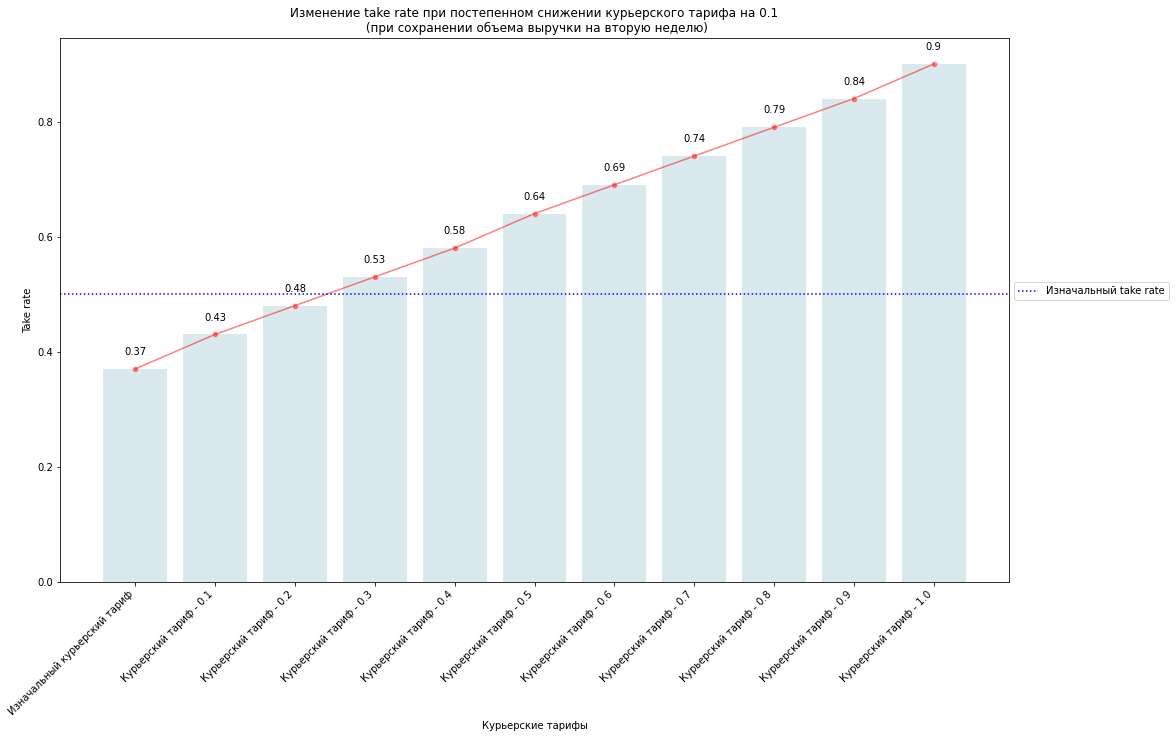

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 10, forward=True)
ax = sns.barplot(x='Курьерские тарифы', y='Take rate', data=take_rate_tariffs_df, alpha=0.5, color='lightblue')
for i in ax.containers:
    ax.bar_label(i, padding=12)
sns.lineplot(x='Курьерские тарифы', y='Take rate', data=take_rate_tariffs_df, marker='o', color='red', alpha=.5)
plt.axhline(y = take_rate_week1, color = 'b', linestyle = ':', label="Изначальный take rate")
plt.title('Изменение take rate при постепенном снижении курьерского тарифа на 0.1\n (при сохранении объема выручки на вторую неделю)')
plt.legend(bbox_to_anchor =(1, 0.56))
plt.xticks(rotation = 45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.rc('font', size=13)
plt.show()

- *Как видно из графика выше, при поэтапном снижении курьерского тарифа за 1 км на 0.1, take rate постоянно возрастает*.
- *Это происходит потому, что издержки снижаются, и даже при прежнем объеме выручке (актуальном на вторую неделю с 20.03.23 - 26.03.23), прибыль растет*.
- *Так как прибыль растет, а выручка остается на том же уровне, take rate увеличивается с каждым снижением курьерской ставки на 0.1*
- *Тем самым, при снижении курьерской ставки, начиная от 0.3, take rate для второй недели не даже немного превышает аналогичный показатель для первой недеои (13.03.23 - 19.03.23) при сохранении объема выручки в 2249 у.е.*

#### 3.1.1 **Вычислим точное значение курьерского тарифа, чтобы выйти на уровень take rate первой недели**

Решим уравнение. В качестве *х* обозначим такой курьерский тариф за 1 км, что при прежнем объеме выручки за вторую неделю (20.03.23 - 26.03.23) take rate за вторую неделю выйдет на take rate первой недели:

In [51]:
dist_by_client

,Client,Distance,Cost,Cost_minus_0.1,Cost_minus_0.2,Cost_minus_0.3,Cost_minus_0.4,Cost_minus_0.5,Cost_minus_0.6,Cost_minus_0.7,Cost_minus_0.8,Cost_minus_0.9,Cost_minus_1.0
0,А,636.341028,763.609234,699.975131,636.341028,572.706926,509.072823,445.438720,381.804617,318.170514,254.536411,190.902309,127.268206
1,Б,437.464589,524.957507,481.211048,437.464589,393.718130,349.971671,306.225212,262.478753,218.732295,174.985836,131.239377,87.492918
2,С,98.785313,118.542376,108.663844,98.785313,88.906782,79.028251,69.149719,59.271188,49.392657,39.514125,29.635594,19.757063


In [52]:
x = symbols('x')
equation = Eq((rev_week2 - (dist_by_client.loc[0]['Distance'] * x + dist_by_client.loc[1]['Distance'] * x + dist_by_client.loc[2]['Distance'] * x)) / 
              rev_week2, take_rate_week1)
solution = solve(equation, x)

print('Необходиая курьерская ставка для достижения прежнего показателя take rate:', round(solution[0], 2))
print('Необходиая сократить курьерская ставку на:', round(courier_rate - solution[0], 2))

Необходиая курьерская ставка для достижения прежнего показателя take rate: 0.96
Необходиая сократить курьерская ставку на: 0.24


- **Тем самым, для достижения показателя take rate первой недели, необходимо сократить курьерску ставку на 0.24, то есть установить курьерскую ставку в 0.96**
- При дальнейшем сокращении курьерской ставки take rate для второй недели начнет превышать take rate для первой недели.

#### 3.2 Сценарий повышения клиентских тарифов при сохранении объема издержек в период 20.03.23 - 26.03.23

In [53]:
deliver_week2 = deliver.query('Week >= "2023-03-20" and Week <= "2023-03-26"')
count_by_client = deliver_week2.groupby('Client').agg({'Num_of_parcels': 'sum'}).reset_index()
count_by_client_tariff = pd.merge(count_by_client, tariff, on='Client')
count_by_client_tariff['Revenue'] = count_by_client_tariff['Num_of_parcels'] * count_by_client_tariff['Tariff_rate']
count_by_client_tariff

,Client,Num_of_parcels,Tariff_rate,Revenue
0,А,191,5.0,955.0
1,Б,161,6.0,966.0
2,С,41,8.0,328.0


Теперь нужно найти оптимальный размер клиентского тарифа так, чтобы увеличенный объем выручки также повысил прибыль при сохранении исходного объема расходов для второй недели. Увеличенный размер прибыли за вторую неделю за счет оптимального клиентского тарифа должнен вывести take rate второй недели на уровень первой.

Решим уравнение, обозначив в качестве *х* оптимальный размер тарифа для каждого клиента А, Б и С соответсвенно:

In [54]:
x = symbols('x')

equation = Eq(((count_by_client_tariff.loc[0]['Num_of_parcels'] * x + count_by_client_tariff.loc[1]['Num_of_parcels'] * x + count_by_client_tariff.loc[2]['Num_of_parcels'] * x) - cost_week2) /
              (count_by_client_tariff.loc[0]['Num_of_parcels'] * x + count_by_client_tariff.loc[1]['Num_of_parcels'] * x + count_by_client_tariff.loc[2]['Num_of_parcels'] * x), take_rate_week1)

solution = solve(equation, [x])
print('Необходиая клиентский тариф для достижения прежнего показателя take rate:', round(solution[0], 2))

Необходиая клиентский тариф для достижения прежнего показателя take rate: 7.15


- **Тем самым, при установке одного клиентского установка клиентского тарифа для каждого клиента в минимальном размере от 7.15 выведет take rate второй недели на уровень перой**
- **В этом сценарии не нужно сокращать расходы на доставки, снижая курьерский тариф**

### 4. Распишите какие шаги могут сопутствовать иннициативам из п.3, какие могут быть трудности/блокеры внедрения иннициатив?

#### 4.1 Дополнительно к инициативам (стратегиям) сохранения take rate на прежнем уровне:

- Коммуникация с клиентами. Важным шагом будет эффективная коммуникация с клиентами относительно изменений в клиентском тарифе. Необходимо объяснить причины повышения тарифа. Например, продемонстрировать заботу о клиентах, напомнив о недопустимости экономии на доставке и сохранении качества обслуживания.  
- Можно попробовать ввести комплексную тарифную ставку. Так, выше определенного километража, клиентский тариф будет расти, а фиксированный тариф оставаться прежним для клиентов. Это менее болезненное решение для клиентов, чем повышение базовых клиентских тарифов. 
- С другой стороны, на определенную по порядку посылку можно давать скидку (например, на каждую 10ую посылку делать скидку), чтобы стимулировать увеличении заказов посылок со стороны клиентов.
- Собирать фидбек у клиентов для улучшения качества обслуживания. Это относится к лояльности клиентов. Нужно удержать клиентов в период предположительного повышения тарифов. Фидбек также ожет казаться отношения клиентов к повышению клиентских тариф (панельное исследование с вопросами: 1) какая цена за доставку посылки для Вас приемлема?; 2) какие улучшения сервиса после повышения цен Вы ожидаете?)
- Проведение тестов. Перед полным масштабным изменением тарифов можно провести тестовые запуски снижения курьерского тарифа или повышения клиентских тарифов на определенных сегментах клиентов или в определенных регионах. Тесты позволят оценить реакцию клиентов, изменение показателей прибыли и выручки (на которых основывается take rate), а также более подробно выявить возможные проблемы или трудности, связанные с внедрением инициатив.

Важно понимать, что эти предварительные предложения не исчерпывающие. Для более эффктивных стратегий нужно собрать больше данных о пользователях (частота заказов для каждого клиента, как часто появляются новые клиенты и т.д.) и провести консультации с маркетинговым отделом.

#### 4.2 Трудности и блокеры:

- Общая рекомендация. При внедрении предложенных инициатив необходимо тщательно оценить финансовую устойчивость и способность компании выдержать убытки или временное снижение прибыли. 
- Решение установить клиентскую тарифную ставку не ниже 7.15 может быть проблематично для одних, хоть и выгодно для остальных. Например, тариф для клиентов А и Б вырастет на 2.15 и 1.15 соответственно, но снизится на 0.85 для клиента С. В результате возможен отток сразу двух клиентов, которые могут не согласиться на повышение тарифов за посылки. 
- Конкуренты не среагирует на повышение клиентских тарифов. Если повысить клиентские тарифы, а конкуренты оставят свои на прежнем уровне, то клиенты будут пользоваться услугами других компаний. Так, необходимо учитывать действия конкурентов и разрабатывать стратегии, чтобы сохранить конкурентоспособность.
- Уровень обслуживания. Снижение курьерского тарифа может повлиять на уровень обслуживания клиентов, например, на время доставки или качество обработки посылок. Важно убедиться, что снижение тарифа не отразится на качестве обслуживания и удовлетворенности клиентов.
- Регуляторные ограничения. Снижение курьерского тарифа может не должно привести к снижению оплаты труда курьеров ниже минимального размера оплаты труда.